Loads Network performance data from ES. Learns to predict bandwidth from packet loss and one way delay.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import re,time
from elasticsearch import Elasticsearch, exceptions as es_exceptions
from elasticsearch.helpers import scan
es = Elasticsearch(hosts=[{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)



In [2]:
ind='network_weather_2-2016.6.22'

currentTime=int(round(datetime.utcnow().timestamp()* 1000))
lastHours=24
startTime=currentTime - lastHours*3600000 
endTime=currentTime

source='MWT2'
destination='AGLT2'

In [3]:
myquery={
#    "size":50,
    "fields": ["timestamp", "delay_mean","throughput","packet_loss"],
    "query":{
        "filtered":{
            "query":{
                "bool" : {
                  "must" :     [ 
                        {"term": {"srcProduction": {"value": True } } },
                        {"term": {"destProduction": {"value": True } } },
                        {"term": {"srcSite": { "value": source } } },
                        {"term": {"destSite": { "value": destination } } }
                    ]
                }
#               "query_string":{"query":queryString,"analyze_wildcard":True,"lowercase_expanded_terms":False}
            }
#            ,"filter":{ "range":{"timestamp":{"gte": startTime,"lte": endTime,"format": "epoch_millis"}}   }
        }
    }
#    ,"sort": { "timestamp": { "order": "asc" }}
}

In [4]:
scroll = scan(es, query=myquery, index=ind, scroll='10s')
RawData={}
count=0
for res in scroll:
    #print(res)
    r = res['fields']
    sts = r['timestamp'][0]
    ts=time.mktime(datetime.strptime(sts, "%Y-%m-%dT%H:%M:%S").timetuple())
    if not ts in RawData:
        RawData[ts]=[-1,-1,-1]
    if res['_type']=='latency':
        RawData[ts][0]=r['delay_mean'][0]
    elif res['_type']=='packet_loss_rate':
        RawData[ts][1]=r['packet_loss'][0]
    elif res['_type']=='throughput':
        RawData[ts][2]=r['throughput'][0]
    count+=1
    
print ("results fetched:", count ) 
print ("results summed up:", len(RawData) ) 

tss = sorted(RawData.keys())
for r in tss:
    print(r, RawData[r])


results fetched: 2582
results summed up: 255
1466561100.0 [8.078533333333334, 0.0, -1]
1466561400.0 [7.062533333333333, 0.0, -1]
1466561700.0 [7.291399999999999, 0.0, -1]
1466562000.0 [6.211533333333333, 0.0, -1]
1466562300.0 [6.234933333333333, 0.0, -1]
1466562600.0 [12.828083333333321, 0.0, -1]
1466562900.0 [5.415233333333334, 0.0, -1]
1466563200.0 [5.751866666666667, 0.0, -1]
1466563500.0 [5.737699999999999, 0.0, -1]
1466563800.0 [6.401833333333333, 0.0, -1]
1466564100.0 [4.886551819949985, 0.0, -1]
1466564400.0 [7.104733333333335, 0.0, -1]
1466564562.0 [-1, -1, 824058322.0]
1466564700.0 [6.715366666666666, 0.0, -1]
1466565000.0 [8.5544, 0.0, -1]
1466565031.0 [-1, -1, 2225659000.0]
1466565300.0 [5.907769256418807, 0.0, -1]
1466565600.0 [5.884866666666667, 0.0, -1]
1466565900.0 [13.335333333333331, 0.0, -1]
1466566200.0 [4.446444444444445, 0.0, -1]
1466566500.0 [4.976499999999998, 0.0, -1]
1466566800.0 [5.773899999999999, 0.0, -1]
1466567100.0 [6.6736999999999975, 0.0, -1]
1466567400

cleaning the data - create array where all 3 components are there.

In [5]:
X=[]
y=[]
for (k,v) in RawData.items():
    if v[2]==-1: continue
    delay_measurements=0
    pl_measurements=0
    delay_sum=0
    pl_sum=0
    for (k1,v1) in RawData.items():
        if abs(k1-k)<600:
            if v1[0]>-1:
                delay_measurements+=1
                delay_sum+=v1[0]
            if v1[1]>-1:
                pl_measurements+=1
                pl_sum+=v1[1]
            #print(k, k1)
    if pl_measurements>0 and delay_measurements>0:
#         print (k, v, delay_sum/delay_measurements, pl_sum/pl_measurements)
        X.append([ delay_sum/delay_measurements, pl_sum/pl_measurements ])
        y.append(v[2]/1024/1024/1024/8)
print(X)
print(y)

[[8.089791783372236, 0.0], [5.873136830108962, 0.0003333333333333333], [5.370948824608202, 0.00022222222222222223], [6.328754166666667, 0.0], [4.9139016394186585, 0.0010833333333333333], [5.4047800211181505, 8.333333333333333e-05], [5.040592522507502, 8.333333333333333e-05], [10.432233333333333, 0.0], [5.608567200533867, 0.0008333333333333333], [5.827696359897744, 8.333333333333333e-05], [6.3044062499999995, 8.333333333333333e-05], [5.436319400911415, 8.333333333333333e-05], [5.64798088607217, 0.0010069444444444444], [6.681458333333333, 0.0], [8.015358450038903, 0.00016666666666666666], [5.594008333333334, 0.0], [6.335050000000001, 0.0], [5.3906888888888895, 0.0], [10.072125528658876, 0.00041666666666666664], [5.195491666666667, 0.0], [5.4997593871891155, 0.00016666666666666666], [5.9417722222222205, 0.0], [6.039097484809751, 8.333333333333333e-05], [4.900181474380349, 0.0], [5.095915491274869, 0.00022222222222222223], [7.922564104474319, 0.00016666666666666666], [7.646150000000001, 8.

takes as input two arrays: an array X of size [n_samples, n_features] holding the training samples, and an array y of class labels (strings or integers), size [n_samples]

Learning step:

In [6]:
from sklearn import svm
# X = [[0, 0], [1, 1], [1, 1.2], [0.5, 0.8]]
#y = [1.2, 2.2]
clf = svm.SVR()
f = clf.fit(X, y)
print(f)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


Using what was learned

In [7]:
clf.predict([[1., .02],[0.1,1.0]])

array([ 0.18168486,  0.18173996])

plot values

In [8]:
na=np.array(X)
print(na)

[[  8.08979178e+00   0.00000000e+00]
 [  5.87313683e+00   3.33333333e-04]
 [  5.37094882e+00   2.22222222e-04]
 [  6.32875417e+00   0.00000000e+00]
 [  4.91390164e+00   1.08333333e-03]
 [  5.40478002e+00   8.33333333e-05]
 [  5.04059252e+00   8.33333333e-05]
 [  1.04322333e+01   0.00000000e+00]
 [  5.60856720e+00   8.33333333e-04]
 [  5.82769636e+00   8.33333333e-05]
 [  6.30440625e+00   8.33333333e-05]
 [  5.43631940e+00   8.33333333e-05]
 [  5.64798089e+00   1.00694444e-03]
 [  6.68145833e+00   0.00000000e+00]
 [  8.01535845e+00   1.66666667e-04]
 [  5.59400833e+00   0.00000000e+00]
 [  6.33505000e+00   0.00000000e+00]
 [  5.39068889e+00   0.00000000e+00]
 [  1.00721255e+01   4.16666667e-04]
 [  5.19549167e+00   0.00000000e+00]
 [  5.49975939e+00   1.66666667e-04]
 [  5.94177222e+00   0.00000000e+00]
 [  6.03909748e+00   8.33333333e-05]
 [  4.90018147e+00   0.00000000e+00]
 [  5.09591549e+00   2.22222222e-04]
 [  7.92256410e+00   1.66666667e-04]
 [  7.64615000e+00   8.33333333e-05]
 

In [9]:
owd=na[:,0]
pl=na[:,1]

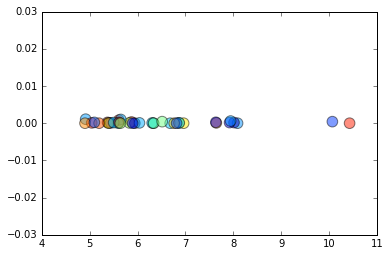

In [10]:
area = np.pi * 6 **2 # 0 to 15 point radiuses

plt.scatter(owd, pl, s=area, c=y, alpha=0.5)
plt.show()